# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Support Vector Classifier Strategy Code

In this notebook, you will learn to use the support vector classifier (SVC) algorithm and its step by step implementation on S&P500. 

SVCs are supervised learning models. A set of training data is provided to the SVC algorithm, each belonging to one of the  categories. For instance, the categories can be either to buy or to sell a stock. The algorithm builds a model during training phase and assigns new data into one of the categories based on the model crated during the training phase.

# Importing the libraries

In [12]:
# Machine learning
from sklearn.svm import SVC
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

# For data manipulation
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
import seaborn

# Downloading S&P500 data

We will download the S&P500 data from IEX finance (if you install the package) otherwise will get data from file.

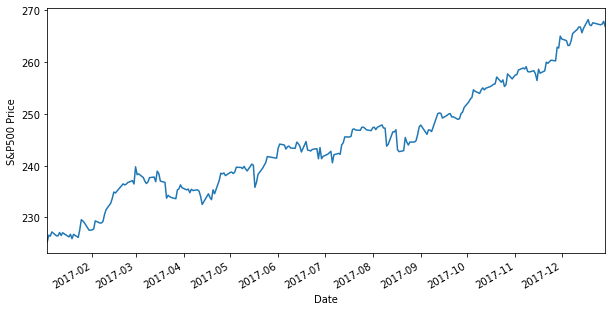

In [13]:
# Fetch the Data
#from iexfinance.stocks import get_historical_data 
from datetime import datetime

#start = datetime(2017, 1, 1) # starting date: year-month-date
#end = datetime(2018, 1, 1) # ending date: year-month-date

#Df = get_historical_data('SPY', start=start, end=end, output_format='pandas')


Df = pd.read_csv("SPY.csv", parse_dates=['Date'])
Df = Df.sort_values(by='Date')
Df.set_index('Date', inplace = True)        

Df= Df.dropna()
Df = Df.rename (columns={'open':'Open', 'high':'High','low':'Low', 'close':'Close'})

Df.Close.plot(figsize=(10,5))
plt.ylabel("S&P500 Price")
plt.show()

# Determine the correct trading signal

If tomorrow's price is greater than today's price then we will buy the S&P500 index, else we will sell the S&P500 index. We will store +1 for buy signal and -1 for sell signal in Signal column. y is a target dataset storing the correct trading signal which the machine learning algorithm will try to predict.

In [14]:
y = np.where(Df['Close'].shift(-1) > Df['Close'],1,-1)

# Creation of predictors datasets

The X is a dataset that holds the variables which are used to predict y, that is, whether the S&P500 index price will go up (1) or go down (-1) tomorrow. The X consists of variables such as 'Open - Close' and 'High - Low'. These can be understood as indicators based on which the algorithm will predict tomorrow's trend. Feel free to add mroe indicators and see the performance.

In [15]:
Df['Open-Close'] = Df.Open - Df.Close
Df['High-Low'] = Df.High - Df.Low
X=Df[['Open-Close','High-Low']]
X.head()

,Open-Close,High-Low
Date,,
2017-01-03,-0.200012,1.949997
2017-01-04,-0.960007,1.139999
2017-01-05,-0.129990,1.100006
2017-01-06,-0.680008,1.850006
2017-01-09,0.449997,0.650009


Text(0, 0.5, 'High-Low')

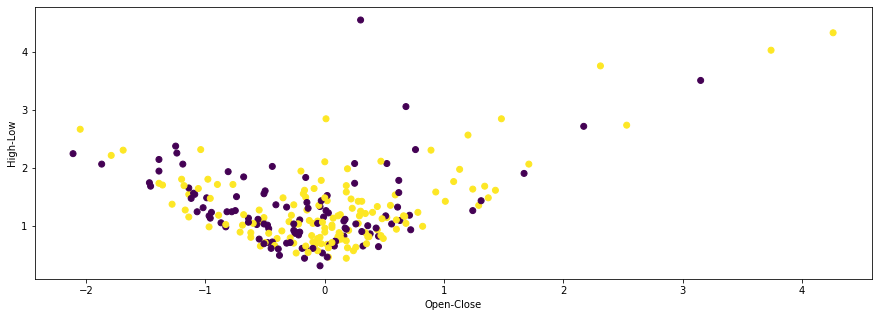

In [16]:
#visualizing the data
plt.figure(figsize=(15, 5))

plt.scatter(Df['Open-Close'], Df['High-Low'],  c=y)
plt.xlabel('Open-Close')
plt.ylabel('High-Low')

# Test and train data set split

Now, we will split data into training and test data set. 

1. First 80% of data is used for training and remaining data for testing.
2. X_train and y_train are training dataset.
3. X_test and y_test are test dataset.

In [17]:
split_percentage = 0.8
split = int(split_percentage*len(Df))

# Train data set
X_train = X[:split]
y_train = y[:split] 

# Test data set
X_test = X[split:]
y_test = y[split:]

#there is another way of doing this split with:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42) #default=0.25 for test_size


# Support Vector Classifier (SVC)

We will use SVC() function from sklearn.svm.SVC library for the classification and create our classifier model using fit() method on the training data set.

In [18]:
cls = SVC().fit(X_train, y_train)
cls

/Users/zhangbeibei/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Classifier accuracy
We will compute the accuarcy of the algorithm on the train and test data set, by comparing the actual values of Signal with the predicted values of Signal. The function accuracy_score() will be used to calculate the accuracy.

<B>Syntax:</B> accuracy_score(<font color=blue>target_actual_value</font>,<font color=blue>target_predicted_value</font>)
1. <font color=blue>target_actual_value:</font> correct signal values
2. <font color=blue>target_predicted_value:</font> predicted signal values

In [19]:
accuracy_train = accuracy_score(y_train, cls.predict(X_train))
accuracy_test = accuracy_score(y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 56.50%
Test Accuracy: 54.90%


An accuracy of 50%+ in test data suggests that the classifier model is effective.

# Prediction

### Predict signal 

We will predict the signal (buy or sell) for the test data set, using the cls.predict() fucntion.

### Compute returns in test period

We will compute the strategy returns based on the predicted signal, and then save it in the column 'Strategy_Return' and plot the cumulative strategy returns.

# Strategy Implementation


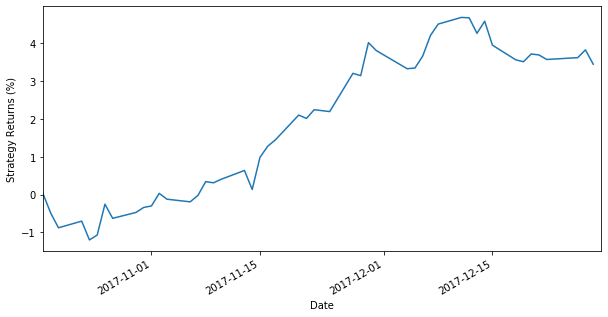

In [20]:
Df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
Df['Strategy_Return'] = Df.Return * Df.Predicted_Signal
Df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

As seen from the graph, the strategy generates a return of 15%+ in the test data set. 

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = [{'kernel': ['rbf'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

Best parameters: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.56


/Users/zhangbeibei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00174837,0.00146546,0.00141401,0.00141864,0.00145941,0.00141854,0.00139737,0.00142217,0.00140519,0.00141864,...,0.0025434,0.00338087,0.00358944,0.00220418,0.00135789,0.00165319,0.00134392,0.00156002,0.00134935,0.0020484
std_fit_time,0.000357226,9.58256e-05,5.66414e-05,4.45738e-05,4.84806e-05,4.5183e-05,6.10165e-05,0.000108206,5.90784e-05,3.25636e-05,...,0.000548293,0.000755215,0.000662671,0.000179589,0.000128178,0.00032613,0.000152664,0.000131304,8.03026e-05,0.000264599
mean_score_time,0.000838566,0.000657034,0.00064187,0.00068059,0.000637245,0.000652218,0.000651073,0.000662613,0.00062685,0.000626373,...,0.000849152,0.000855875,0.000957298,0.000839567,0.000701952,0.000768948,0.000739622,0.000733948,0.000753212,0.000762844
std_score_time,0.000181637,4.63797e-05,2.21508e-05,5.15539e-05,1.5969e-05,4.21173e-05,4.93174e-05,4.31727e-05,8.38664e-06,1.71529e-06,...,0.000206985,0.000220419,0.000323171,0.000220959,0.000138432,0.00029278,0.000253331,0.000180224,0.000276803,0.00023739
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,...,0.560976,0.487805,0.536585,0.463415,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976
split1_test_score,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,...,0.560976,0.536585,0.512195,0.512195,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe = Pipeline([("scaler", MinMaxScaler()),("svm", SVC())])

param_grid = [{'svm__kernel': ['rbf'], 
               'svm__C': [0.001, 0.01, 0.1, 10, 100], 
                'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'svm__kernel': ['linear'],
              'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

Best parameters: {'svm__C': 0.001, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.56


/Users/zhangbeibei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
mean_fit_time,0.00316052,0.00212069,0.00208964,0.00207319,0.00205822,0.00216155,0.00205479,0.00207038,0.00207849,0.00206957,...,0.00319777,0.00319867,0.00333443,0.0043963,0.00190473,0.00189414,0.00190558,0.00194917,0.00185089,0.00202885
std_fit_time,0.00118617,0.000125024,0.00010093,0.000150908,7.64194e-05,0.000136012,6.04032e-05,0.000126862,4.93081e-05,4.6969e-05,...,0.000245699,0.00135596,0.000514403,0.00044589,0.000100599,7.11828e-05,6.97321e-05,4.21653e-05,2.86545e-05,0.000176899
mean_score_time,0.00102143,0.000725079,0.000764513,0.0007236,0.00071702,0.000746584,0.000709629,0.000729799,0.000780106,0.000739574,...,0.000805044,0.000766325,0.00077343,0.00086565,0.000701761,0.000711012,0.000718784,0.000680161,0.000722599,0.000689602
std_score_time,0.000485491,1.90588e-05,5.94923e-05,1.77835e-05,1.55814e-05,5.27977e-05,2.98014e-06,2.9483e-05,8.84221e-05,5.38089e-05,...,0.000130218,8.09744e-05,5.57431e-05,0.000226439,5.0152e-05,6.86343e-05,5.90297e-05,4.89171e-06,5.13984e-05,1.82515e-05
param_svm__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_svm__gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_svm__kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'svm__C': 0.001, 'svm__gamma': 0.001, 'svm__k...","{'svm__C': 0.001, 'svm__gamma': 0.01, 'svm__ke...","{'svm__C': 0.001, 'svm__gamma': 0.1, 'svm__ker...","{'svm__C': 0.001, 'svm__gamma': 1, 'svm__kerne...","{'svm__C': 0.001, 'svm__gamma': 10, 'svm__kern...","{'svm__C': 0.001, 'svm__gamma': 100, 'svm__ker...","{'svm__C': 0.01, 'svm__gamma': 0.001, 'svm__ke...","{'svm__C': 0.01, 'svm__gamma': 0.01, 'svm__ker...","{'svm__C': 0.01, 'svm__gamma': 0.1, 'svm__kern...","{'svm__C': 0.01, 'svm__gamma': 1, 'svm__kernel...",...,"{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kerne...","{'svm__C': 100, 'svm__gamma': 1, 'svm__kernel'...","{'svm__C': 100, 'svm__gamma': 10, 'svm__kernel...","{'svm__C': 100, 'svm__gamma': 100, 'svm__kerne...","{'svm__C': 0.001, 'svm__kernel': 'linear'}","{'svm__C': 0.01, 'svm__kernel': 'linear'}","{'svm__C': 0.1, 'svm__kernel': 'linear'}","{'svm__C': 1, 'svm__kernel': 'linear'}","{'svm__C': 10, 'svm__kernel': 'linear'}","{'svm__C': 100, 'svm__kernel': 'linear'}"
split0_test_score,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,...,0.560976,0.560976,0.512195,0.512195,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976
split1_test_score,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976,...,0.560976,0.560976,0.512195,0.585366,0.560976,0.560976,0.560976,0.560976,0.560976,0.560976
